In [4]:
from mxnet import gluon
from mxnet import ndarray as nd

/home/zyc/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
def transform(data,label):
    return data.astype('float32')/255,label.astype('float32')

In [6]:
mnist_train = gluon.data.vision.FashionMNIST(root='../Mx/datasets/fashion-mnist/',train=True,transform=transform)
mnist_test = gluon.data.vision.FashionMNIST(root='../Mx/datasets/fashion-mnist/',train=False,transform=transform)

/home/zyc/anaconda3/lib/python3.6/site-packages/mxnet/gluon/data/vision/datasets.py:118: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  label = np.fromstring(fin.read(), dtype=np.uint8).astype(np.int32)
/home/zyc/anaconda3/lib/python3.6/site-packages/mxnet/gluon/data/vision/datasets.py:122: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  data = np.fromstring(fin.read(), dtype=np.uint8)


### 数据读取

In [7]:
batch_size = 256
train_data = gluon.data.DataLoader(mnist_train,batch_size,shuffle=True)
test_data = gluon.data.DataLoader(mnist_test,batch_size,shuffle=False)

In [5]:
num_inputs = 28*28
num_outputs = 10

num_hidden = 256
weight_scale = .01

W1 = nd.random_normal(shape=(num_inputs,num_hidden),scale=weight_scale)
b1 = nd.zeros(num_hidden)

W2 = nd.random_normal(shape=(num_hidden,num_outputs),scale = weight_scale)
b2 = nd.zeros(num_outputs)

params = [W1,b1,W2,b2]

for param in params:
    param.attach_grad()

# 从0开始【不是异界生活】
### 激活函数

如果用线性操作符来构造多层神经网络，那么整个网络任然是一个线性，这是因为  
$y’ = X*W_1*W_2 = X*W_3$  

### $relu(x)=max(x,0)$

In [14]:
def relu(x):
    return nd.maximum(x,0)

### 定义模型  
就是将各个层串联起来（输入层-隐藏层[relu]-输出层）

In [15]:
def net(X):
    X = X.reshape((-1,num_inputs))
    h1 = relu(nd.dot(X,W1)+b1)
    output = nd.dot(h1,W2)+b2
    return output

### Softmax 和交叉损失函数

In [16]:
from mxnet import gluon
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()

#### 三个轮子函数

In [34]:
def SGD(params,lr):
    for param in params:
        param[:] = param-lr*param.grad

In [35]:
def accuracy(output,label):
    return nd.mean(output.argmax(axis=1)==label).asscalar()

In [36]:
def evaluate_accuracy(data_iterator,net):
    acc = 0
    for data,label in data_iterator:
        output = net(data)
        acc += accuracy(output,label)
    return acc/len(data_iterator)

### 训练

In [1]:
from mxnet import autograd as autograd

learning_rate = 0.1

for epoch in range(5):
    train_loss = 0.
    train_acc = 0.
    for data,label in train_data:
        with autograd.record():
            output = net(data)
            loss = softmax_cross_entropy(output,label)
        loss.backward()
        SGD(params,learning_rate/batch_size)
        
        train_loss += nd.mean(loss).asscalar()
        train_acc += accuracy(output,label)
        
    test_acc = evaluate_accuracy(test_data,net)
    print("Epoch %d. Loss: %f, Train acc %f,Test acc %f"%\
         (epoch,train_loss/len(train_data),train_acc/len(train_data),
         test_acc))       

/home/zyc/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


NameError: name 'train_data' is not defined

# 多层感知机---使用Gluon

### 定义模型

In [13]:
from mxnet import gluon

net = gluon.nn.Sequential()
with net.name_scope():
    net.add(gluon.nn.Flatten())   #输入矩阵，可以不用管输入多大
    #net.add(gluon.nn.Dense(256,activation='relu'))   #隐藏层
    net.add(gluon.nn.Dense(128,activation='relu'))
    #net.add(gluon.nn.Dense(64,activation='relu'))
    #net.add(gluon.nn.Dense(32,activation='relu'))
    #net.add(gluon.nn.Dense(16,activation='relu'))
    net.add(gluon.nn.Dense(10))   #输出层
net.initialize()

### 读取数据

In [14]:
from mxnet import autograd
from mxnet import ndarray as nd

batch_size = 256
train_data = gluon.data.DataLoader(mnist_train,batch_size,shuffle=True)
test_data = gluon.data.DataLoader(mnist_test,batch_size,shuffle=False)

### softmax_entropy   
记得运行三个轮子

In [15]:
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()
trainer = gluon.Trainer(net.collect_params(),'sgd',{'learning_rate':0.5})

for epoch in range(5):
    train_loss = 0.
    train_acc = 0.
    for data,label in train_data:
        with autograd.record():
            output = net(data)
            loss = softmax_cross_entropy(output,label)
        loss.backward()
        trainer.step(batch_size)
        
        train_loss += nd.mean(loss).asscalar()
        train_acc += accuracy(output,label)
        
    test_acc = evaluate_accuracy(test_data,net)
    print("Epoch %d. Loss: %f, Train acc %f,Test acc %f"%\
         (epoch,train_loss/len(train_data),train_acc/len(train_data),
         test_acc)) 

Epoch 0. Loss: 0.775452, Train acc 0.709619,Test acc 0.810937
Epoch 1. Loss: 0.489875, Train acc 0.817431,Test acc 0.852344
Epoch 2. Loss: 0.431344, Train acc 0.840365,Test acc 0.863770
Epoch 3. Loss: 0.394186, Train acc 0.854654,Test acc 0.856934
Epoch 4. Loss: 0.374004, Train acc 0.861275,Test acc 0.867480


# 欠拟合和过拟合

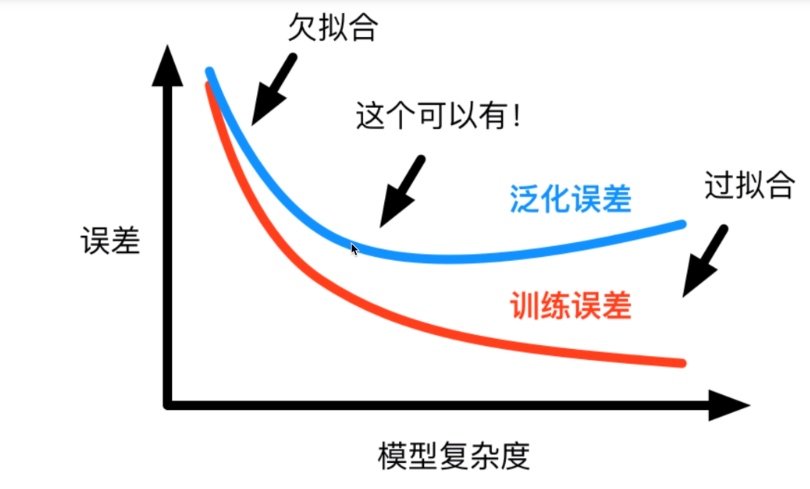

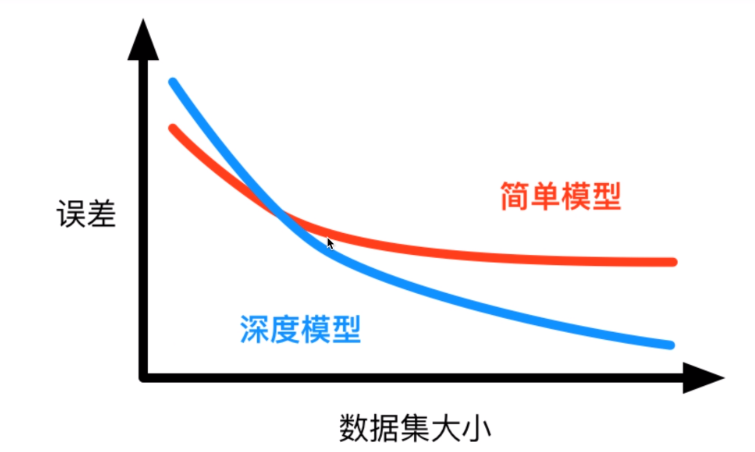

### 多项式拟合

#### 函数：   
$y = 1.2x-3.4x^2+5.6x^3+5.0+noise$

In [9]:
from mxnet import ndarray as nd
from mxnet import autograd
from mxnet import gluon

num_train=100
num_test = 100
true_w = [1.2,-3.4,5.6]
true_b = 5.0

生成数据集

In [11]:
x = nd.random.normal(shape=(num_train+num_test,1))  #200*1的矩阵
X = nd.concat(x,nd.power(x,2),nd.power(x,3))
y = true_w[0]*X[:,0]+true_w[1]*X[:,1]+true_w[2]*X[:,2]+true_b
y += .1*nd.random_normal(shape=y.shape)
y_train,y_test = y[:num_train],y[num_train:]

In [13]:
X.shape,y.shape

((200, 3), (200,))

### 定义训练和测试

In [14]:
import matplotlib as mpl
mpl.rcParams['figure.dpi']=120
import matplotlib.pyplot as plt

def test(net,X,y):
    return square_loss(net(X),y).mean().ascalar()

def train(X_train,X_test,y_train,y_test):
    #线性回归模型
    net = gluon.nn.Sequential()
    with net.name_scope():
        net.add(gluon.nn.Dense(1))
    net.initialize()
    
    #设置默认参数
    learning_rate = .01
    epochs = 100
    
    #batch_size = min(1,y_train.shape[0])
    batch_size = 10
    dataset_train = gluon.data.ArrayDataset(X_train,y_train)
    data_iter_train = gluon.data.DataLoader(
        dataset_train,batch_size,shuffle=True)
    #默认均方误差
    trainer = gluon.Trainer(net.collect_params(),'sgd',{'learning_rate':learning_rate})
    square_loss = gluon.loss.L2Loss()
    
    #保存训练和损失
    train_loss = []
    test_loss=[]
    for e in range(epochs):
        for data,label in data_iter_train:
            with autograd.record():
                output=net(data)
                loss = square_loss(output,label)
            loss.backward()
            trainer.step(batch_size)
        train_loss.append(square_loss(
            net(X_train),y_train).mean().asscalar())
        test_loss.append(square_loss(
            net(X_test),y_test).mean().asscalar())
    #打印结果
    plt.plot(train_loss)
    plt.plot(test_loss)
    plt.legend(['train','test'])
    plt.show()
    return ('learned weight',net[0].weight.data(),
           'learned bias',net[0].bias.data())

### 三项拟合  【正常】

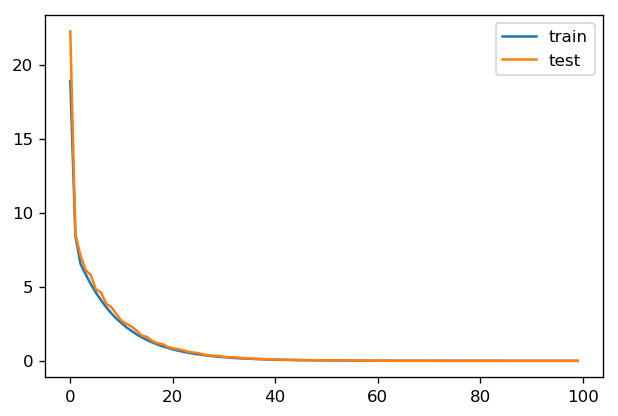

('learned weight', 
 [[ 1.1783968 -3.395498   5.604304 ]]
 <NDArray 1x3 @cpu(0)>, 'learned bias', 
 [4.993445]
 <NDArray 1 @cpu(0)>)

In [16]:
train(X[:num_train,:],X[num_train:,:],y[:num_train],y[num_train:])

### 线性拟合【欠拟合】

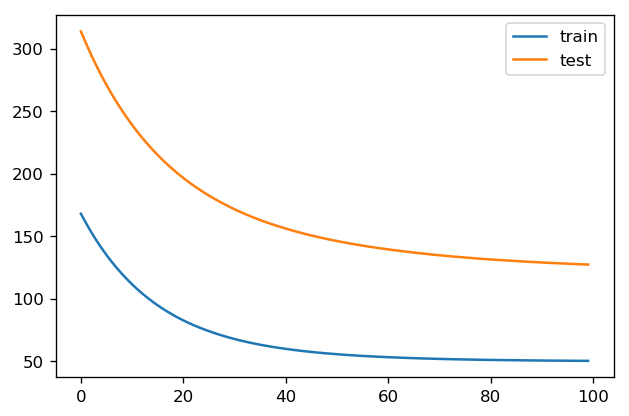

('learned weight', 
 [[14.063319]]
 <NDArray 1x1 @cpu(0)>, 'learned bias', 
 [4.206502]
 <NDArray 1 @cpu(0)>)

In [17]:
train(x[:30,:],x[num_train:,:],y[:30],y[num_train:])

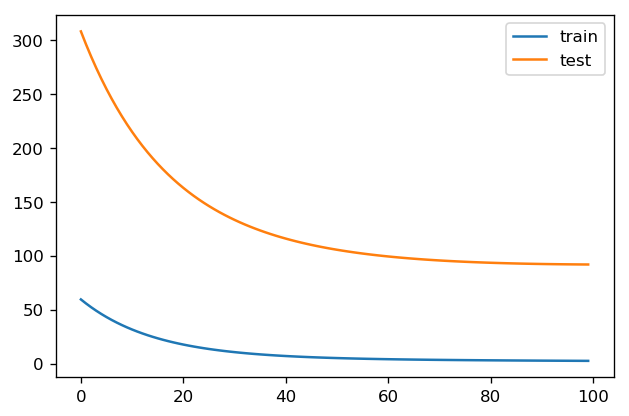

('learned weight', 
 [[0.9669395 1.9806813 3.0410707]]
 <NDArray 1x3 @cpu(0)>, 'learned bias', 
 [1.8561608]
 <NDArray 1 @cpu(0)>)

In [22]:
train(X[0:5,:],X[num_train:,:],y[0:5],y[num_train:])

# 正则化---从0开始

In [142]:
from mxnet import ndarray as nd
from mxnet import autograd
from mxnet import gluon
import mxnet as mx

In [143]:
num_train=20
num_test = 100
num_inputs = 200

### 生成数据集

In [144]:
true_w = nd.ones((num_inputs,1)) * 0.01
true_b = 0.05

In [145]:
X = nd.random.normal(shape=(num_train + num_test,num_inputs))
x = nd.dot(X,true_w) + true_b
y += .01*nd.random_normal(shape=y.shape)

X_train,X_test = X[:num_train,:],X[num_train:,:]
y_trian,y_test = y[:num_train],y[num_train:]

In [146]:
import random
batch_size = 1
def data_iter(num_examples):
    idx = list(range(num_examples))
    random.shuffle(idx)
    for i in range(0,num_examples,batch_size):
        j = nd.array(idx[i:min(i+batch_size,num_examples)])
        yield X.take(j),y.take(j)

### 初始化模型参数

In [147]:
def init_params():
    w = nd.random_normal(scale=1,shape=(num_inputs,1))
    b = nd.zeros(shape=(1,))
    params = [w,b]
    for param in params:
        param.attach_grad()
    return params

In [148]:
def L2_penalty(w,b):
    return ((w**2).sum()+(b**2))/2

### 定义测试和训练

In [149]:
import matplotlib.pyplot as plt
import numpy as np

In [150]:
def net(X,w,b):
    return(nd.dot(X,w)+b)

def square_loss(yhat,y):
    return (yhat-y.reshape(yhat.shape))**2/2

def sgd(params,lr,batch_size):
    for param in params:
        param[:] = param-lr*param.grad/batch_size
        
def test(net,params,X,y):
    return square_loss(net(X,*params),y).mean().asscalar()

In [175]:
def train(lambd):
    epochs = 10
    learning_rate = 0.05
    w,b = params=init_params()
    train_loss = []
    test_loss = []
    for e in range(epochs):
        for data,label in data_iter(num_train):
            with autograd.record():
                output = net(data,*params)
                loss = square_loss(
                    output,label)+lambd*L2_penalty(*params)
            loss.backward()
            sgd(params,learning_rate,batch_size)
        train_loss.append(test(net,params,X_train,y_train))
        test_loss.append(test(net,params,X_test,y_test))
    plt.plot(train_loss)
    plt.plot(test_loss)
    plt.legend(['train','test'])
    plt.show()
    return ('learned w[:10]',w[:10].T,'learned b',b)       

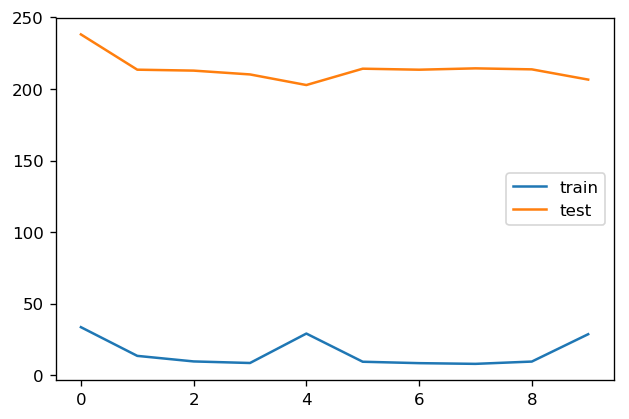

('learned w[:10]', 
 [[ 0.28857863  0.05324239 -0.21719277  0.00477905  0.15437797  0.29665422
    0.09342417 -0.08148291  0.15036054 -0.05022695]]
 <NDArray 1x10 @cpu(0)>, 'learned b', 
 [0.64371425]
 <NDArray 1 @cpu(0)>)

In [212]:
train(4)
### 我滴个乖乖，loss这么高

# 正则化---使用Gluon

In [195]:
from mxnet import ndarray as nd
from mxnet import autograd
from mxnet import gluon
import mxnet as mx

In [213]:
num_train = 20 
num_test = 100
num_inputs = 200

true_w = nd.ones((num_inputs,1)) * 0.01
true_b = 0.05

X = nd.random.normal(shape=(num_train+num_test,num_inputs))
y = nd.dot(X,true_w) + true_b
y += .01*nd.random.normal(shape=y.shape)

X_train,X_test = X[:num_train,:],X[num_train:,:]
y_train,y_test = y[:num_train],y[num_train:]

In [219]:
X_train.shape,y_train.shape

((20, 200), (20, 1))

In [220]:
X_test.shape,y_test.shape

((100, 200), (100, 1))

### 定义训练和测试

In [222]:
batch_size=1
dataset_train = gluon.data.ArrayDataset(X_train,y_train)
data_iter_train = gluon.data.DataLoader(dataset_train,batch_size,shuffle=True)

square_loss = gluon.loss.L2Loss()

def test(net,X,y):   #为什么没用X_train ，y_train或者X_test,y_test
    return square_loss(net(X),y).mean().asscalar()   

def train(weight_decay):
    epochs = 10
    learning_rate=0.005
    net = gluon.nn.Sequential()
    with net.name_scope():
        net.add(gluon.nn.Dense(1))
    net.collect_params().initialize(mx.init.Normal(sigma=1))
    
    trainer = gluon.Trainer(net.collect_params(),'sgd',{'learning_rate':learning_rate,'wd':weight_decay})
    
    train_loss = []
    test_loss = []
    
    for e in range(epochs):
        for data,label in data_iter_train:
            with autograd.record():
                output = net(data)
                loss = square_loss(output,label)
            loss.backward()
            trainer.step(batch_size)
        train_loss.append(test(net,X_train,y_train))
        test_loss.append(test(net,X_test,y_test))
    plt.plot(train_loss)
    plt.plot(test_loss)
    plt.legend(['train','test'])
    plt.show()
    
    return ('learned w[:10]',net[0].weight.data()[:,:10],
           'learned b:',net[0].bias.data())

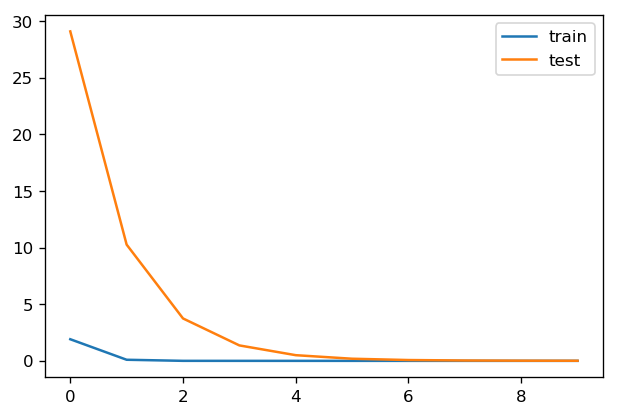

('learned w[:10]', 
 [[ 6.1619901e-03 -9.6440893e-03  6.4270073e-03 -9.0444053e-05
    4.2348038e-03 -2.6457985e-03  1.1300946e-02 -2.7813835e-03
   -3.3776797e-03 -7.9988001e-04]]
 <NDArray 1x10 @cpu(0)>, 'learned b:', 
 [0.00456123]
 <NDArray 1 @cpu(0)>)

In [224]:
train(5)

# ----
## 一些GPU操作
# ----

# 卷积神经网络---从0开始

In [226]:
from mxnet import nd

w = nd.arange(4).reshape((1,1,2,2))
b = nd.array([1])

data = nd.arange(9).reshape((1,1,3,3))
out = nd.Convolution(data,w,b,kernel=w.shape[2:],num_filter=w.shape[1])

print('input->',data,'\n\nweight->',w,'\n\nbias->',b,'\n\noutput->',out)
print('W*f+b')

input-> 
[[[[0. 1. 2.]
   [3. 4. 5.]
   [6. 7. 8.]]]]
<NDArray 1x1x3x3 @cpu(0)> 

weight-> 
[[[[0. 1.]
   [2. 3.]]]]
<NDArray 1x1x2x2 @cpu(0)> 

bias-> 
[1.]
<NDArray 1 @cpu(0)> 

output-> 
[[[[20. 26.]
   [38. 44.]]]]
<NDArray 1x1x2x2 @cpu(0)>
W*f+b


### 如何控制移动：stride:每次移动多少，pad：边缘填充

In [235]:
out = nd.Convolution(data,w,b,kernel=w.shape[2:],num_filter=w.shape[1],
                    stride=(1,1),pad=(1,1))

print('input->',data,'\n\nweight->',w,'\n\nbias->',b,'\n\noutput->',out)


input-> 
[[[[0. 1. 2.]
   [3. 4. 5.]
   [6. 7. 8.]]]]
<NDArray 1x1x3x3 @cpu(0)> 

weight-> 
[[[[0. 1.]
   [2. 3.]]]]
<NDArray 1x1x2x2 @cpu(0)> 

bias-> 
[1.]
<NDArray 1 @cpu(0)> 

output-> 
[[[[ 1.  4.  9.  5.]
   [10. 20. 26. 11.]
   [22. 38. 44. 17.]
   [ 7.  8.  9.  1.]]]]
<NDArray 1x1x4x4 @cpu(0)>


In [242]:
w = nd.arange(16).reshape((2,2,2,2))     #[几个weight,两层，长，宽]
data = nd.arange(18).reshape((1,2,3,3))  #[,两层，长，宽]

b = nd.array([1,2])
out = nd.Convolution(data,w,b,kernel=w.shape[2:],num_filter=w.shape[0])

print('input->',data,'\n\nweight->',w,'\n\nbias->',b,'\n\noutput->',out)

###  第一个和第一层卷积，之后两层加起来输出

input-> 
[[[[ 0.  1.  2.]
   [ 3.  4.  5.]
   [ 6.  7.  8.]]

  [[ 9. 10. 11.]
   [12. 13. 14.]
   [15. 16. 17.]]]]
<NDArray 1x2x3x3 @cpu(0)> 

weight-> 
[[[[ 0.  1.]
   [ 2.  3.]]

  [[ 4.  5.]
   [ 6.  7.]]]


 [[[ 8.  9.]
   [10. 11.]]

  [[12. 13.]
   [14. 15.]]]]
<NDArray 2x2x2x2 @cpu(0)> 

bias-> 
[1. 2.]
<NDArray 2 @cpu(0)> 

output-> 
[[[[ 269.  297.]
   [ 353.  381.]]

  [[ 686.  778.]
   [ 962. 1054.]]]]
<NDArray 1x2x2x2 @cpu(0)>


### 池化层 【pooling】

In [244]:
data = nd.arange(18).reshape((1,2,3,3))
#常用两种池化方法
max_pool = nd.Pooling(data=data,pool_type='max',kernel=(2,2))
avg_pool = nd.Pooling(data=data,pool_type='avg',kernel=(2,2))

print('data->',data,'\n\nmax_pooling->',max_pool,'\n\navg_pooling->',avg_pool)

data-> 
[[[[ 0.  1.  2.]
   [ 3.  4.  5.]
   [ 6.  7.  8.]]

  [[ 9. 10. 11.]
   [12. 13. 14.]
   [15. 16. 17.]]]]
<NDArray 1x2x3x3 @cpu(0)> 

max_pooling-> 
[[[[ 4.  5.]
   [ 7.  8.]]

  [[13. 14.]
   [16. 17.]]]]
<NDArray 1x2x2x2 @cpu(0)> 

avg_pooling-> 
[[[[ 2.  3.]
   [ 5.  6.]]

  [[11. 12.]
   [14. 15.]]]]
<NDArray 1x2x2x2 @cpu(0)>


### 实际案例  获取数据

In [8]:
def transform(data,label):
    return data.astype('float32')/255,label.astype('float32')

In [9]:
mnist_train = gluon.data.vision.FashionMNIST(root='../Mx/datasets/fashion-mnist/',train=True,transform=transform)
mnist_test = gluon.data.vision.FashionMNIST(root='../Mx/datasets/fashion-mnist/',train=False,transform=transform)

/home/zyc/anaconda3/lib/python3.6/site-packages/mxnet/gluon/data/vision/datasets.py:118: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  label = np.fromstring(fin.read(), dtype=np.uint8).astype(np.int32)
/home/zyc/anaconda3/lib/python3.6/site-packages/mxnet/gluon/data/vision/datasets.py:122: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  data = np.fromstring(fin.read(), dtype=np.uint8)


In [10]:
batch_size = 256
train_data = gluon.data.DataLoader(mnist_train,batch_size,shuffle=True)
test_data = gluon.data.DataLoader(mnist_test,batch_size,shuffle=False)

### 定义模型

In [59]:
import mxnet as mx

weight_scale = .01

#output channels = 20,kernel=(5,5)
W1 = nd.random_normal(shape=(20,1,5,5),scale=weight_scale)
b1 = nd.zeros(W1.shape[0])

#out put channels = 50,kernel = (3,3)
W2 = nd.random_normal(shape=(50,20,3,3),scale=weight_scale)
b2 = nd.zeros(W2.shape[0])
#output dim = 128
W3 = nd.random_normal(shape=(1250,128),scale=weight_scale)
b3 = nd.zeros(W3.shape[1])

#output dim = 10
W4 = nd.random_normal(shape=(W3.shape[1],10),scale=weight_scale)
b4 = nd.zeros(W4.shape[1])

params = [W1,b1,W2,b2,W3,b3,W4,b4]
for param in params:
    param.attach_grad()

In [60]:
def net(X,verbose=False):
    #X = X.as_in_context(W1,context)   针对数据不在同一处理器
    #第一层卷积
    h1_conv = nd.Convolution(data=X,weight=W1,bias=b1,kernel=W1.shape[2:],num_filter=W1.shape[0])
    h1_activation = nd.relu(h1_conv)
    h1 = nd.Pooling(data=h1_activation,pool_type='max',kernel=(2,2),stride=(2,2))
    
    #第二层卷积
    h2_conv = nd.Convolution(data=h1,weight=W2,bias=b2,kernel=W2.shape[2:],num_filter=W2.shape[0])
    h2_activation = nd.relu(h2_conv)
    h2 = nd.Pooling(data=h2_activation,pool_type='max',kernel=(2,2),stride=(2,2))
    h2 = nd.flatten(h2)    #转换成1维
    
    #第一层全连接层
    h3_linear = nd.dot(h2,W3) + b3
    h3 = nd.relu(h3_linear)
    
    #第二层全连接层
    h4_liner = nd.dot(h3,W4) + b4
    
    if verbose:
        print('1st conv block:',h1.shape)
        print('2nd conv block:',h2.shape)
        print('1st Dense:',h3.shape)
        print('2nd Dense:',h4_liner.shape)
        print('output:',h4_liner)
        
    return h4_liner

In [67]:
for data, _ in train_data:
    net(data[:].reshape([-1,1,28,28]),verbose=True)
    break   

1st conv block: (256, 20, 12, 12)
2nd conv block: (256, 1250)
1st Dense: (256, 128)
2nd Dense: (256, 10)
output: 
[[-5.5631579e-05 -3.9102950e-05 -3.2255371e-05 ...  2.6612608e-05
  -7.6072665e-06  2.5675956e-05]
 [-9.1822330e-05 -3.4685341e-05 -1.6899887e-05 ...  6.0846956e-05
   5.6883368e-05  6.7101028e-05]
 [-6.0956267e-05 -5.8606198e-05 -2.6827607e-05 ...  5.0175535e-05
   2.2664166e-05  3.4700261e-05]
 ...
 [-7.7392906e-05 -4.7307727e-05 -1.8181643e-05 ...  4.2558964e-05
   6.0424791e-05  3.9613315e-05]
 [ 6.9476009e-06 -9.2578106e-05 -5.9513561e-05 ...  1.4185987e-05
   1.7714512e-05  1.5214778e-05]
 [-4.5530767e-05 -1.8427192e-05 -1.7845354e-05 ...  2.4356477e-05
   2.3912587e-05  2.1988233e-05]]
<NDArray 256x10 @cpu(0)>


# 卷积网络---Gluon实现

In [73]:
def SGD(params,lr):
    for param in params:
        param[:] = param-lr*param.grad

In [74]:
def accuracy(output,label):
    return nd.mean(output.argmax(axis=1)==label).asscalar()

In [81]:
def evaluate_accuracy(data_iterator,net):
    acc = 0
    for data,label in data_iterator:
        output = net(data[:].reshape([-1,1,28,28]))
        acc += accuracy(output,label)
    return acc/len(data_iterator)

In [82]:
from mxnet import gluon

net = gluon.nn.Sequential()

with net.name_scope():
    net.add(gluon.nn.Conv2D(channels=20,kernel_size=5,activation='relu'))
    net.add(gluon.nn.MaxPool2D(pool_size=2,strides=2))
    net.add(gluon.nn.Conv2D(channels=50,kernel_size=3,activation='relu'))
    net.add(gluon.nn.MaxPool2D(pool_size=2,strides=2))
    net.add(gluon.nn.Flatten())
    net.add(gluon.nn.Dense(128,activation='relu'))
    net.add(gluon.nn.Dense(10))
net.initialize()

In [84]:
from mxnet import autograd as autograd
from mxnet import nd

batch_size=256
softmax_corss_entropy = gluon.loss.SoftmaxCrossEntropyLoss()
trainer = gluon.Trainer(net.collect_params(),'sgd',{'learning_rate':0.5})
train_acc = 0.
test_acc = 0.

for epoch in range(5):
    train_loss=0.
    test_loss =0.
    for data,label in train_data:
        label = label#.as_in_context(ctx)
        with autograd.record():
            output = net(data[:].reshape([-1,1,28,28]))
            loss = softmax_corss_entropy(output,label)
        loss.backward()
        trainer.step(batch_size)
        
        train_loss += nd.mean(loss).asscalar()
        train_acc += accuracy(output,label)
    test_acc = evaluate_accuracy(test_data,net)
    print("Epoch %d. Loss: %f, Train acc %f,Test acc %f"%\
         (epoch,train_loss/len(train_data),train_acc/len(train_data),
         test_acc)) 

Epoch 0. Loss: 0.510996, Train acc 0.804028,Test acc 0.831543
Epoch 1. Loss: 0.419842, Train acc 1.645202,Test acc 0.855176
Epoch 2. Loss: 0.376344, Train acc 2.503951,Test acc 0.867383
Epoch 3. Loss: 0.350079, Train acc 3.372257,Test acc 0.877246
Epoch 4. Loss: 0.325376, Train acc 4.248493,Test acc 0.870605


In [62]:
# data1 = data[:10] #测试数据

In [63]:
# data2 = data1.reshape([-1,1,28,28])   #测试数据

In [64]:
# data2.shape #测试数据用

(10, 1, 28, 28)

In [85]:
#net(data2,verbose=True)  测试数据用